# Setup Workspace

In [1]:
import warnings
import nltk

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter
from tqdm.auto import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from torchtext.vocab import GloVe

In [2]:
nltk.download('stopwords')
nltk.download("wordnet", '/root/nltk_data')
tqdm.pandas()
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
DATA_PATH = 'src/q_quora.csv'
STOP_WORDS = set(stopwords.words('english'))
GLOVE = GloVe(name="6B", dim=50)

100%|█████████▉| 399999/400000 [00:14<00:00, 28364.84it/s]


# Exploratory Data Analysis

In [4]:
df = pd.read_csv(DATA_PATH)

df = df.drop(columns=[
    'Unnamed: 6',
    'Unnamed: 7',
    'Unnamed: 8',
    'Unnamed: 9',
    'Unnamed: 10',
    'Unnamed: 11',
    'Unnamed: 12'
], axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Data columns
**id:** id for a training set question pair

**qid1,qid2:** unique ids of each question 

**question1, question2:** the full text of the question

**is_duplicate: target label:** 1: two questions have the same meaning, 0: two questions do not have the same meaning

Our dataset consists of over 400,000 lines of potential question duplicate pairs. Each line contains IDs for each question in the pair, the full text for each question, and a binary value that indicates whether the line truly contains a duplicate pair.

In [5]:
print('Shape of the dataframe:', df.shape)
print("Column's name:", df.columns)

Shape of the dataframe: (15761, 6)
Column's name: Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


In [6]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate    object
dtype: object

### Ratio between duplicates questions pairs
In our dataset's elegant asymmetry, non-duplicate questions dominate at 63%, casting a vast net of diversity. Meanwhile, the 37% of duplicate questions echo a shared resonance, creating a compelling contrast. 

In [7]:
df = df[(df['is_duplicate'] == "0") | (df['is_duplicate'] == "1")]
df.is_duplicate.value_counts()

is_duplicate
0    9840
1    5906
Name: count, dtype: int64

In [8]:
is_duplicate_counts = df['is_duplicate'].value_counts()

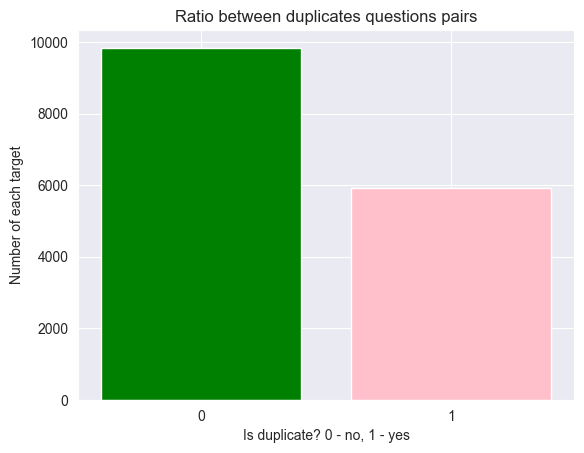

In [9]:
colors = {"0": "green", "1": "pink"}

_, ax = plt.subplots()
ax.bar(
    is_duplicate_counts.index,
    is_duplicate_counts.values,
    tick_label=["0", "1"],
    color=[colors[str(x)] for x in is_duplicate_counts.index]
)

ax.set_title('Ratio between duplicates questions pairs')
ax.set_xlabel('Is duplicate? 0 - no, 1 - yes')
ax.set_ylabel('Number of each target')
ax.set_xticks([0, 1])

plt.show()

In [10]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [11]:
df = df.dropna(subset=['question1', 'question2'])

### Distribution of Question Lengths

In [12]:
df['q1_length'] = df['question1'].apply(len)
df['q2_length'] = df['question2'].apply(len)

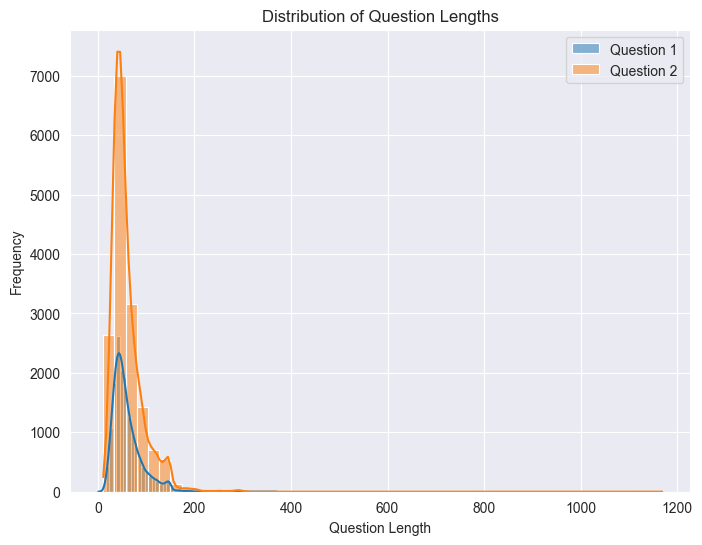

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(df['q1_length'], bins=50, label='Question 1', kde=True)
sns.histplot(df['q2_length'], bins=50, label='Question 2', kde=True)
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Question Lengths')
plt.show()

In [14]:
min_q_length = min(df['q1_length'].min(), df['q2_length'].min())
max_q_length = max(df['q1_length'].max(), df['q2_length'].max())

print("Minimum length of question:", min_q_length)
print("Maximum length of question:", max_q_length)

Minimum length of question: 1
Maximum length of question: 1169


### Analyzing Special Characters

In [15]:
df['q1_special_chars'] = df['question1'].apply(lambda x: len([char for char in str(x) if char.isalnum() == False]))
df['q2_special_chars'] = df['question2'].apply(lambda x: len([char for char in str(x) if char.isalnum() == False]))

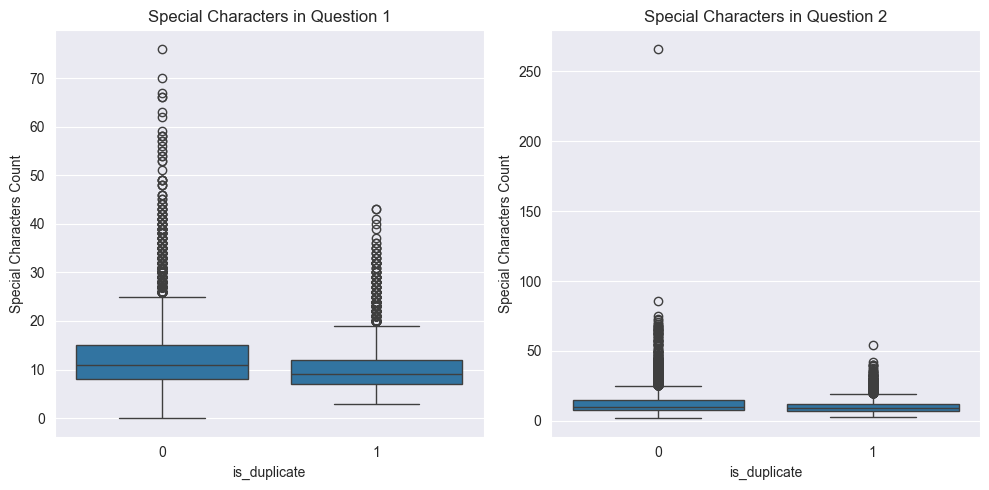

In [16]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.boxplot(x='is_duplicate', y='q1_special_chars', data=df, ax=axes[0])
axes[0].set_title('Special Characters in Question 1')
axes[0].set_xlabel('is_duplicate')
axes[0].set_ylabel('Special Characters Count')

sns.boxplot(x='is_duplicate', y='q2_special_chars', data=df, ax=axes[1])
axes[1].set_title('Special Characters in Question 2')
axes[1].set_xlabel('is_duplicate')
axes[1].set_ylabel('Special Characters Count')

plt.tight_layout()
plt.show()

### Analyzing Stopwords

In [17]:
df['q1_stopwords'] = df['question1'].apply(
    lambda x: len([word for word in str(x).lower().split() if word in STOP_WORDS])
)

df['q2_stopwords'] = df['question2'].apply(
    lambda x: len([word for word in str(x).lower().split() if word in STOP_WORDS])
)

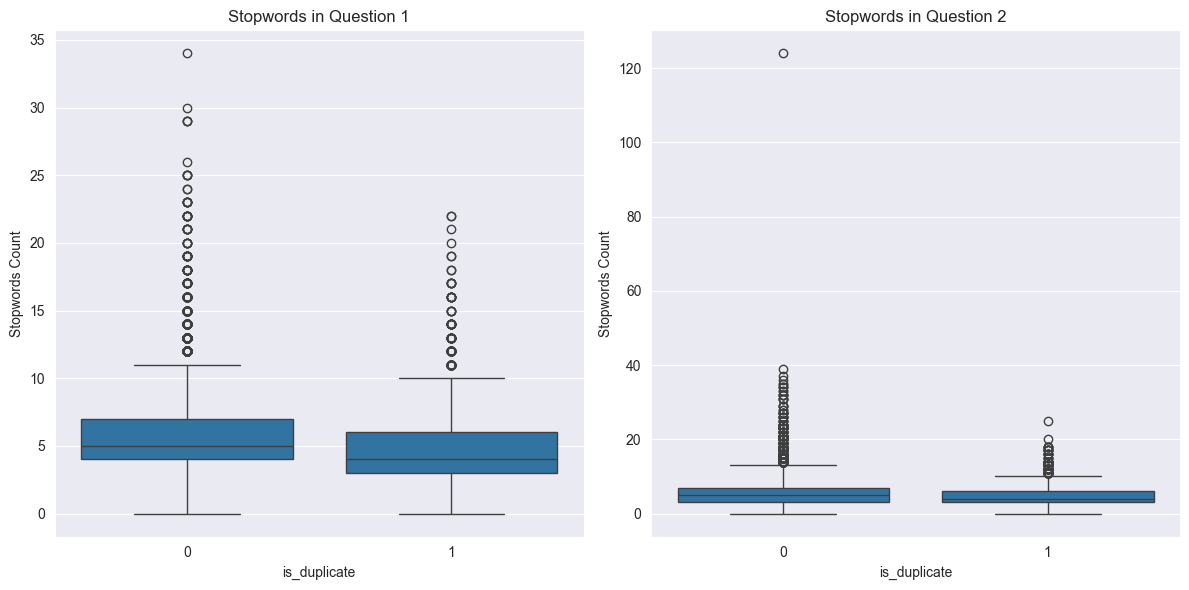

In [18]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(x='is_duplicate', y='q1_stopwords', data=df, ax=axes[0])
axes[0].set_title('Stopwords in Question 1')
axes[0].set_xlabel('is_duplicate')
axes[0].set_ylabel('Stopwords Count')

sns.boxplot(x='is_duplicate', y='q2_stopwords', data=df, ax=axes[1])
axes[1].set_title('Stopwords in Question 2')
axes[1].set_xlabel('is_duplicate')
axes[1].set_ylabel('Stopwords Count')

plt.tight_layout()
plt.show()

### Word Clouds for Questions

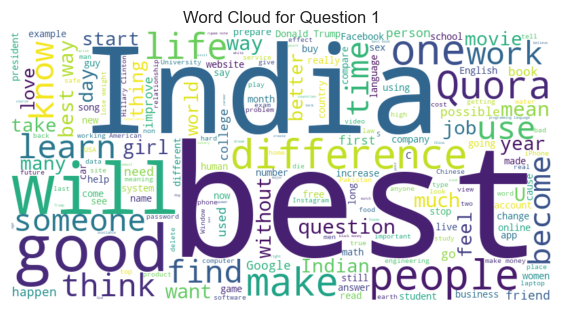

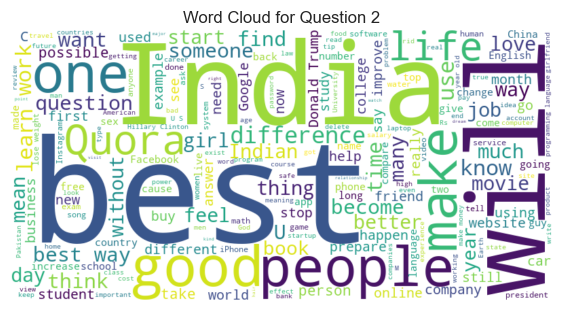

In [19]:
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['question1']))
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Question 1')
plt.show()

wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['question2']))
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Question 2')
plt.show()

### Common Words in Questions

In [20]:
words_question1 = ' '.join(df['question1']).lower().split()
words_question2 = ' '.join(df['question2']).lower().split()

counter_question1 = Counter(words_question1)
counter_question2 = Counter(words_question2)

print("Most common words in Question 1:", counter_question1.most_common(10))
print("Most common words in Question 2:", counter_question2.most_common(10))

Most common words in Question 1: [('the', 7339), ('what', 6089), ('is', 5164), ('how', 4273), ('i', 4072), ('to', 3842), ('in', 3833), ('a', 3827), ('of', 3117), ('do', 3039)]
Most common words in Question 2: [('the', 7249), ('what', 6081), ('is', 5242), ('i', 4405), ('how', 4236), ('to', 4167), ('a', 4160), ('in', 3851), ('do', 3122), ('of', 3074)]


### Common words between question1 and question2

In the elegant tableau of our box plot, a clear story emerges. Duplicated questions (is_duplicate = 1) reveal a rich tapestry of shared words. On average, these questions exhibit a deeper linguistic kinship, as indicated by a higher count of common words. It's a testament to their inherent similarity, a poetic dance of language and meaning.

In [21]:
df['common_words'] = df.apply(
    lambda row: set(row['question1'].lower().split()).intersection(set(row['question2'].lower().split())),
    axis=1
)

df['common_words_count'] = df['common_words'].apply(len)

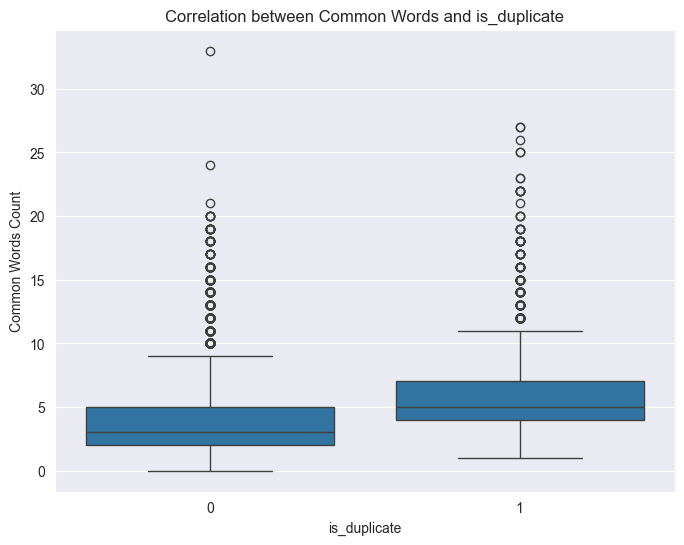

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_duplicate', y='common_words_count', data=df)
plt.title('Correlation between Common Words and is_duplicate')
plt.xlabel('is_duplicate')
plt.ylabel('Common Words Count')
plt.show()

### Unigrams Frequency Analysis

In [23]:
df['questions_combined'] = df['question1'] + ' ' + df['question2']
vectorizer = CountVectorizer(stop_words='english')
unigrams = vectorizer.fit_transform(df['questions_combined'])
unigram_frequencies = np.array(unigrams.sum(axis=0)).squeeze()

In [24]:
feature_names = vectorizer.get_feature_names_out()

unigram_freq_df = pd.DataFrame({'unigram': feature_names, 'frequency': unigram_frequencies})
unigram_freq_df = unigram_freq_df.sort_values(by='frequency', ascending=False)

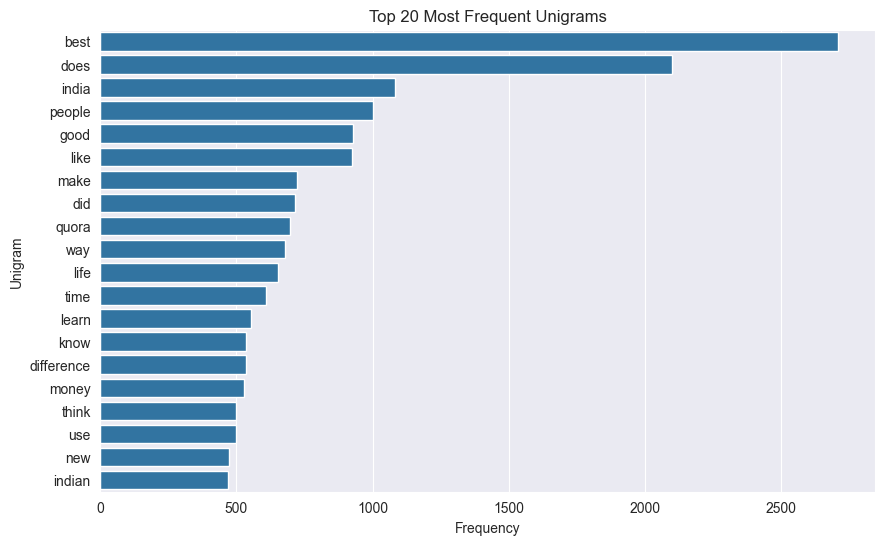

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='unigram', data=unigram_freq_df.head(20))
plt.xlabel('Frequency')
plt.ylabel('Unigram')
plt.title('Top 20 Most Frequent Unigrams')
plt.show()

### Unigrams Length Analysis

In [26]:
unigram_lengths = df['questions_combined'].apply(lambda x: len(str(x).split()))

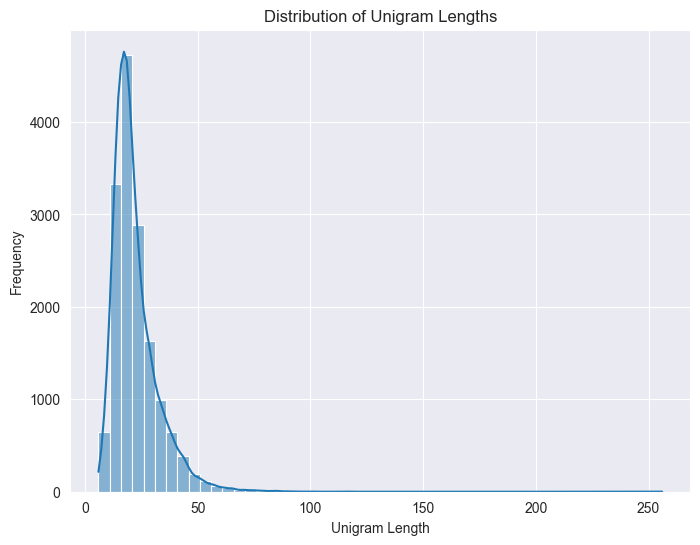

In [27]:
plt.figure(figsize=(8, 6))
sns.histplot(unigram_lengths, bins=50, kde=True)
plt.xlabel('Unigram Length')
plt.ylabel('Frequency')
plt.title('Distribution of Unigram Lengths')
plt.show()

In [28]:
min_unigram_length = unigram_lengths.min()
max_unigram_length = unigram_lengths.max()

print("Minimum length of unigram:", min_unigram_length)
print("Maximum length of unigram:", max_unigram_length)

Minimum length of unigram: 6
Maximum length of unigram: 256


### Store Result

In [29]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,q1_special_chars,q2_special_chars,q1_stopwords,q2_stopwords,common_words,common_words_count,questions_combined
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,7,6,"{by, invest, is, guide, to, in, what, step, sh...",10,What is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,12,17,4,4,"{(koh-i-noor), the, kohinoor, what}",4,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,8,5,"{can, internet, speed, how}",4,How can I increase the speed of my internet co...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,12,18,7,4,{},0,Why am I mentally very lonely? How can I solve...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,15,7,3,2,"{which, in}",2,"Which one dissolve in water quikly sugar, salt..."


In [30]:
%store df
df.to_csv('formated_dataframe.csv', index=False)

Stored 'df' (DataFrame)
